In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return pd.Series(result)

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return pd.Series(result)

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    E_y = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x_value, y_value)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin,xmax])
    print(type(xl))
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    E_y = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(x_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:238: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:243: SyntaxWarning: invalid escape sequence '\p'
<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:238: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:243: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_3252\1214479212.py:235: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_3252\1214479212.py:238: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_3252\1214479212.py:240: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

[-1.000e-03  2.291e+00]
k, b = $417 \pm 28$ $123 \pm 38$


,I,F1,F2,B
0,$0.190 \pm 0.010$,$1.900 \pm 0.050$,$2.800 \pm 0.050$,$120.0 \pm 9.6$
1,$0.390 \pm 0.010$,$1.900 \pm 0.050$,$3.700 \pm 0.050$,$240.0 \pm 10.0$
2,$0.560 \pm 0.010$,$1.900 \pm 0.050$,$4.500 \pm 0.050$,$347 \pm 11$
3,$0.760 \pm 0.010$,$1.900 \pm 0.050$,$5.400 \pm 0.050$,$467 \pm 11$
4,$0.930 \pm 0.010$,$1.900 \pm 0.050$,$6.100 \pm 0.050$,$560 \pm 12$
5,$1.110 \pm 0.010$,$1.900 \pm 0.050$,$6.800 \pm 0.050$,$653 \pm 13$
6,$1.300 \pm 0.010$,$1.900 \pm 0.050$,$7.400 \pm 0.050$,$733 \pm 14$
7,$1.490 \pm 0.010$,$1.900 \pm 0.050$,$7.900 \pm 0.050$,$800 \pm 14$
8,$1.630 \pm 0.010$,$2.100 \pm 0.050$,$8.400 \pm 0.050$,$840 \pm 15$
9,$1.840 \pm 0.010$,$2.100 \pm 0.050$,$8.600 \pm 0.050$,$867 \pm 15$


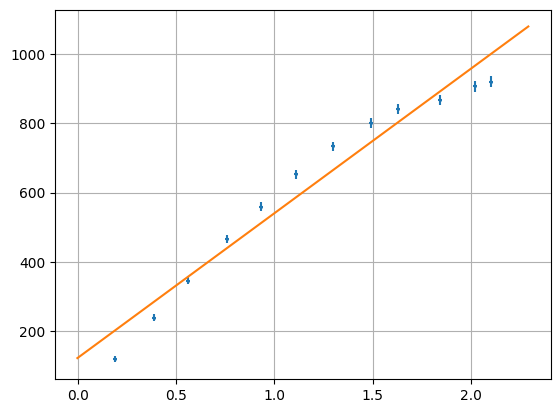

In [92]:
SN = DData(75,1,E=-4)
dataWB = pd.read_csv("dataWB.csv")

dataWB["I"] = dataWB["I"].apply(lambda x: DData(x, 0.01))
dataWB["F1"] = dataWB["F1"].apply(lambda x: DData(x, 0.05,E=-3))
dataWB["F2"] = dataWB["F2"].apply(lambda x: DData(x, 0.05,E=-3))
dataWB["B"] = (dataWB["F2"]-dataWB["F1"])/SN
DData.changeEInSerias(dataWB["B"],-3)
linearcalc_error(dataWB["I"],dataWB["B"])
dataWB

In [93]:
def B(I):
    for i in range(len(dataWB)):
        if(I<dataWB["I"][i].value):
            B1 = dataWB["B"][i-1]
            B2 = dataWB["B"][i]
            I1 = dataWB["I"][i-1].value
            I2 = dataWB["I"][i].value
            return(B1 + (B2-B1)*(I-I1)/(I2-I1))
        
print(B(2))

$902 \pm 24$


In [94]:
#Напряжение в мкВ, ток в мА
L35 = DData(3.0,0.1,E=-3)
a = DData(1.5,0.1,E=-3)
l = DData(1.7,0.1,E=-3)
U35 = DData(1.686,E=-3)
I_35 = DData(1,0.01,E=-3)
sigma = I_35 * L35/(U35*a*l)
sigma.E=0
print(sigma)


$698 \pm 67$


In [95]:
data34 = pd.read_csv("data34.csv")
data34["U34"] = data34["U34"].apply(lambda x: DData(x,1,E=-6))
data34["U0"] = data34["U0"].apply(lambda x: DData(x,1,E=-6))
data34["I"] = data34["I"].apply(lambda x: DData(x,0.01,E=0))
data34["I0"] = data34["I0"].apply(lambda x: DData(x,0.01,E=-3))
data34["E_holl"] = data34["U34"]-data34["U0"]
data34

,I,U34,U0,I0,E_holl
0,$0.190 \pm 0.010$,$32.0 \pm 1.0$,$17.0 \pm 1.0$,$0.300 \pm 0.010$,$15.0 \pm 1.4$
1,$0.560 \pm 0.010$,$68.0 \pm 1.0$,$17.0 \pm 1.0$,$0.300 \pm 0.010$,$51.0 \pm 1.4$
2,$0.930 \pm 0.010$,$102.0 \pm 1.0$,$17.0 \pm 1.0$,$0.300 \pm 0.010$,$85.0 \pm 1.4$
3,$1.300 \pm 0.010$,$128.0 \pm 1.0$,$17.0 \pm 1.0$,$0.300 \pm 0.010$,$111.0 \pm 1.4$
4,$1.660 \pm 0.010$,$146.0 \pm 1.0$,$17.0 \pm 1.0$,$0.300 \pm 0.010$,$129.0 \pm 1.4$
5,$2.020 \pm 0.010$,$157.0 \pm 1.0$,$17.0 \pm 1.0$,$0.300 \pm 0.010$,$140.0 \pm 1.4$
6,$0.190 \pm 0.010$,$42.0 \pm 1.0$,$18.0 \pm 1.0$,$0.400 \pm 0.010$,$24.0 \pm 1.4$
7,$0.560 \pm 0.010$,$90.0 \pm 1.0$,$18.0 \pm 1.0$,$0.400 \pm 0.010$,$72.0 \pm 1.4$
8,$0.930 \pm 0.010$,$135.0 \pm 1.0$,$18.0 \pm 1.0$,$0.400 \pm 0.010$,$117.0 \pm 1.4$
9,$1.300 \pm 0.010$,$170.0 \pm 1.0$,$18.0 \pm 1.0$,$0.400 \pm 0.010$,$152.0 \pm 1.4$


In [96]:
data34["B"] = data34["I"].apply(lambda x: B(x))

def srez_I0(I0 : float):
    return data34[get_values(data34["I0"]) == I0]

def calc_k(i0):
    data_srez  = srez_I0(i0)
    data_srez.index = range(len(data_srez))
    k,_ = linearcalc_error(data_srez["B"], data_srez["E_holl"])
    return k

[ 41.33333333 985.33333333]
k, b = $0.15788 \pm 0.00096$ $-3.87 \pm 0.62$
[ 41.33333333 985.33333333]
k, b = $0.2120 \pm 0.0017$ $-1.7 \pm 1.1$
[ 41.33333333 985.33333333]
k, b = $0.2638 \pm 0.0019$ $-1.2 \pm 1.2$
[ 41.33333333 985.33333333]
k, b = $0.3213 \pm 0.0018$ $-4.7 \pm 1.1$
[ 41.33333333 985.33333333]
k, b = $0.3768 \pm 0.0035$ $-6.3 \pm 2.3$
[ 41.33333333 985.33333333]
k, b = $0.4242 \pm 0.0025$ $-3.5 \pm 1.6$
[ 41.33333333 985.33333333]
k, b = $0.4810 \pm 0.0022$ $-6.6 \pm 1.4$
[ 41.33333333 985.33333333]
k, b = $0.5229 \pm 0.0085$ $-5.8 \pm 5.5$


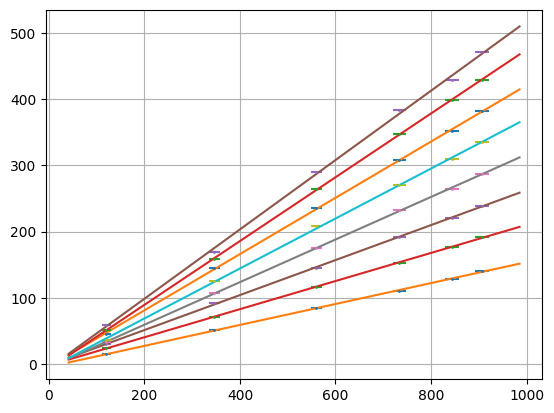

In [97]:
EI = pd.DataFrame()
EI["I0"] = [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
EI["k"] = EI["I0"].apply(lambda x: calc_k(x))

[0.23 1.07]
k, b = $0.5282 \pm 0.0066$ $0.0016 \pm 0.0046$
$0.5282 \pm 0.0066$
$1.182 \pm 0.015$


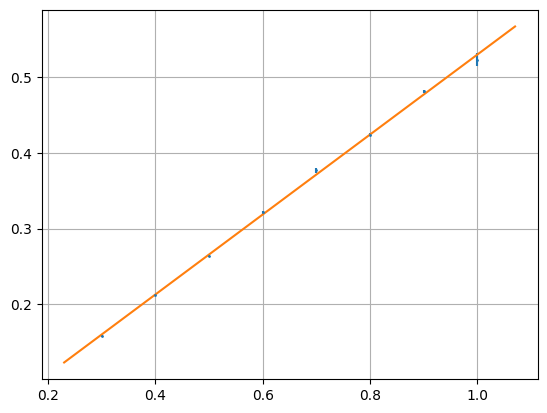

In [98]:
Rx, _ = linearcalc_error(EI["I0"],EI["k"])
print(Rx)
n = 1/Rx/DData(1.602,E=-19)
n.E=22
print(n)